In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns

from IPython.display import display_html

import xgboost as xgb
from xgboost import plot_importance

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# hp: define o espaço do hyperparâmetro
# fmin: função de otimização
# Trials: avalia os diferentes hiperparâmetros pesquisados
from hyperopt import hp, fmin, Trials

# status de retorno da função
from hyperopt import STATUS_OK, STATUS_FAIL

# opções de algoritmos de busca
from hyperopt import rand, anneal, tpe

In [2]:
# CONFIGURAÇÃO PARA MOSTRAR TODAS COLUNAS DOS DATAFRAMEE
pd.set_option("display.max_columns", None)

# CONFIGURAÇÃO PARA NÃO MOSTRAR AVISOS
import warnings
warnings.filterwarnings('ignore')

In [3]:
# CARREGANDO CONJUNTO DE DADOS

dataset = pd.read_csv('MiningProcess_Flotation_Plant_Database.csv')

# <CENTER>Análise dos Dados

In [4]:
# VISUALIZAÇÃO DO DATASET

dataset.head(5)

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235","250,576","295,096","306,4","250,225","250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532","250,862","295,096","306,4","250,137","248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874","250,313","295,096","306,4","251,345","248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487","250,049","295,096","306,4","250,422","251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136","249,895","295,096","306,4","249,983","248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


In [5]:
# SHAPE DO CONJUNTO DE DADOS

dataset.shape

(737453, 24)

In [6]:
# INFORMAÇÕES REFERENTE AO DATAFRAME

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date                          737453 non-null  object
 1   % Iron Feed                   737453 non-null  object
 2   % Silica Feed                 737453 non-null  object
 3   Starch Flow                   737453 non-null  object
 4   Amina Flow                    737453 non-null  object
 5   Ore Pulp Flow                 737453 non-null  object
 6   Ore Pulp pH                   737453 non-null  object
 7   Ore Pulp Density              737453 non-null  object
 8   Flotation Column 01 Air Flow  737453 non-null  object
 9   Flotation Column 02 Air Flow  737453 non-null  object
 10  Flotation Column 03 Air Flow  737453 non-null  object
 11  Flotation Column 04 Air Flow  737453 non-null  object
 12  Flotation Column 05 Air Flow  737453 non-null  object
 13 

In [7]:
# SUBSTITUINDO ALGUMAS PALAVRAS, CARACTERES ESPECIAIS E ESPAÇOS DOS NOMES DAS COLUNAS

dataset.columns = dataset.columns.str.replace('Column ', '')
dataset.columns = dataset.columns.str.replace('% ', '')
dataset.columns = dataset.columns.str.replace(' ', '_')
dataset.columns = dataset.columns.str.lower()

In [8]:
# RENOMEANDO NOME DA COLUNA
dataset.rename(columns={'date': 'datetime'}, inplace=True)

# CONVERTENDO DATA PARA PADRÃO DATETIME
dataset['datetime'] = pd.to_datetime(dataset['datetime'])

# CRIANDO NOVAS COLUNAS COM VALORES DE DATA E HORA SEPARADOS
dataset['date'] = dataset['datetime'].dt.date
dataset['day'] = dataset['datetime'].dt.day
dataset['month'] = dataset['datetime'].dt.month
dataset['year'] = dataset['datetime'].dt.year
dataset['hour'] = dataset['datetime'].dt.hour

In [9]:
# SUBSTITUINDO HORA 0 PARA HORA 24
dataset['hour'] = dataset['hour'].replace(0, 24)

# SELECIONANDO ATRIBUTOS COM EXCEÇÕES DE ALGUNS
type_feature = [x for x in list(dataset.columns) if x not in ['datetime', 'time', 'date', 'day', 'month', 'year', 'hour']]

In [10]:
# SUBSTITUINDO VÍRGULA POR PONTO NAS VARIÁVEIS NUMÉRICAS SELECIONADAS ACIMA

for feature in type_feature:
    dataset[feature] = dataset[feature].apply(lambda x: float(str(x).replace(',', '.')))

In [11]:
# ORDENANDO DADOS POR MEIO DA DATA E HORA

dataset = dataset.sort_values(by='datetime')

In [12]:
# VISUALIZANDO DATAFRAME

dataset.head()

,datetime,iron_feed,silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,flotation_01_air_flow,flotation_02_air_flow,flotation_03_air_flow,flotation_04_air_flow,flotation_05_air_flow,flotation_06_air_flow,flotation_07_air_flow,flotation_01_level,flotation_02_level,flotation_03_level,flotation_04_level,flotation_05_level,flotation_06_level,flotation_07_level,iron_concentrate,silica_concentrate,date,day,month,year,hour
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74000,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31,2017-03-10,10,3,2017,1
111,2017-03-10 01:00:00,55.2,16.98,3185.55,586.182,404.648,10.1139,1.73614,250.488,250.488,249.214,295.096,306.4,250.137,248.950,450.139,510.332,461.638,422.888,451.528,510.098,513.904,66.91,1.31,2017-03-10,10,3,2017,1
112,2017-03-10 01:00:00,55.2,16.98,3182.03,595.947,407.168,10.1135,1.73545,250.620,252.334,249.390,295.096,306.4,256.465,251.499,440.530,518.600,465.414,405.704,433.686,513.794,512.252,66.91,1.31,2017-03-10,10,3,2017,1
113,2017-03-10 01:00:00,55.2,16.98,3180.86,600.464,402.598,10.1130,1.73476,250.576,250.620,249.258,295.096,306.4,250.137,250.269,443.833,510.446,456.246,415.706,428.618,481.874,468.224,66.91,1.31,2017-03-10,10,3,2017,1
114,2017-03-10 01:00:00,55.2,16.98,1272.66,594.971,393.516,10.1125,1.73407,250.488,249.302,249.302,295.096,306.4,247.983,248.511,453.242,502.968,451.604,441.878,427.296,433.372,412.824,66.91,1.31,2017-03-10,10,3,2017,1


In [13]:
# DESCRIÇÃO DOS ATRIBUTOS

dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
iron_feed,737453.0,56.294739,5.157744,42.740000,52.670000,56.080000,59.720000,65.78000
silica_feed,737453.0,14.651716,6.807439,1.310000,8.940000,13.850000,19.600000,33.40000
starch_flow,737453.0,2869.140569,1215.203734,0.002026,2076.320000,3018.430000,3727.730000,6300.23000
amina_flow,737453.0,488.144697,91.230534,241.669000,431.796000,504.393000,553.257000,739.53800
ore_pulp_flow,737453.0,397.578372,9.699785,376.249000,394.264000,399.249000,402.968000,418.64100
ore_pulp_ph,737453.0,9.767639,0.387007,8.753340,9.527360,9.798100,10.038000,10.80810
ore_pulp_density,737453.0,1.680380,0.069249,1.519820,1.647310,1.697600,1.728330,1.85325
flotation_01_air_flow,737453.0,280.151856,29.621288,175.510000,250.281000,299.344000,300.149000,373.87100
flotation_02_air_flow,737453.0,277.159965,30.149357,175.156000,250.457000,296.223000,300.690000,375.99200
flotation_03_air_flow,737453.0,281.082397,28.558268,176.469000,250.855000,298.696000,300.382000,364.34600


In [14]:
# COPIANDO DATASET PARA UMA NOVA VARIÁVEL

df = dataset.copy(deep=True)

In [15]:
# VISALIZANDO ATRIBUTOS COM MENORES CARDINALDADE OU VALORES ÚNICOS

print('Atributos com menores cardinalidade:')

for feature in df.columns:
    if len(df[feature].unique()) < 100:
        print('{}: {}'.format(feature, len(df[feature].unique())))

Atributos com menores cardinalidade:
day: 31
month: 7
year: 1
hour: 24


In [16]:
# DELETANDO COLUNA 'YEAR', POIS TEMOS SOMENTE DADOS DE UM ÚNICO ANO

df = df.drop(columns=['year'])

In [17]:
# FUNÇÃO PARA DIVIDIR O CONJUNTO DE DADOS EM TREINO E TESTE

def split_data(df, porcentage):
    row = int(len(df)*porcentage)
    train = df.iloc[:row ,:]
    test = df.iloc[row: ,:]
    return train ,test    

In [18]:
# ATRIBUINDO DADOS DE TREINO COM 80% E TESTE COM 20%, SENDO ELES OS ÚLTIMOS REGISTROS (para não tirar da ordem cronológica do datetime)

df_train, df_test = split_data(df, 0.8)

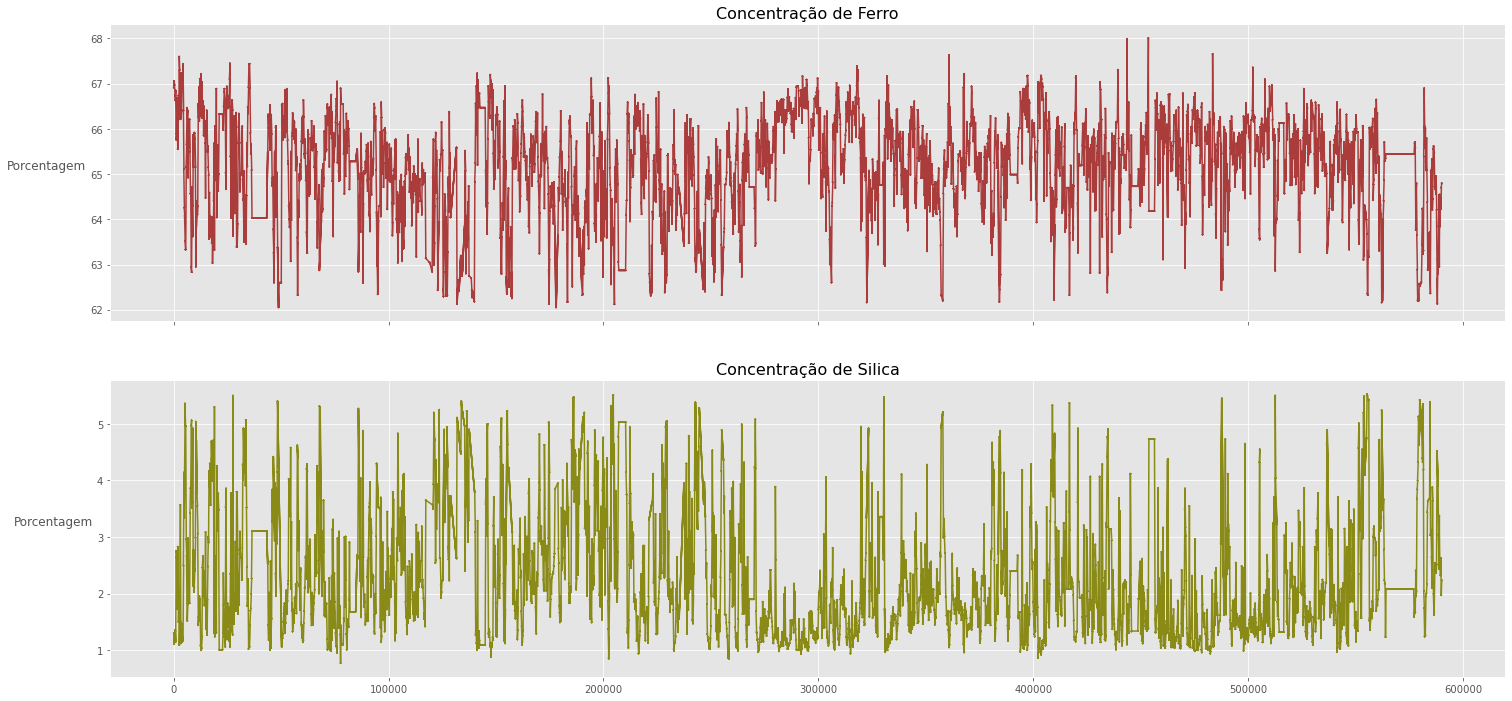

In [19]:
# PLOTANDO VARIÁVEIS ALVO

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True, sharey='row', figsize=(25,12))
    
ax = axes[0]
ax.set_title('Concentração de Ferro', fontdict=dict(fontsize=16))    
ax.plot(df_train['iron_concentrate'], color='brown', linestyle='-', alpha=0.9)
ax.set_ylabel('Porcentagem', rotation = 0, horizontalalignment = 'right') 
    
ax = axes[1]
ax.set_title('Concentração de Silica', fontdict=dict(fontsize=16))    
ax.plot(df_train['silica_concentrate'], color='olive', linestyle='-', alpha=0.9)
ax.set_ylabel('Porcentagem', rotation = 0, horizontalalignment = 'right') 

plt.show()

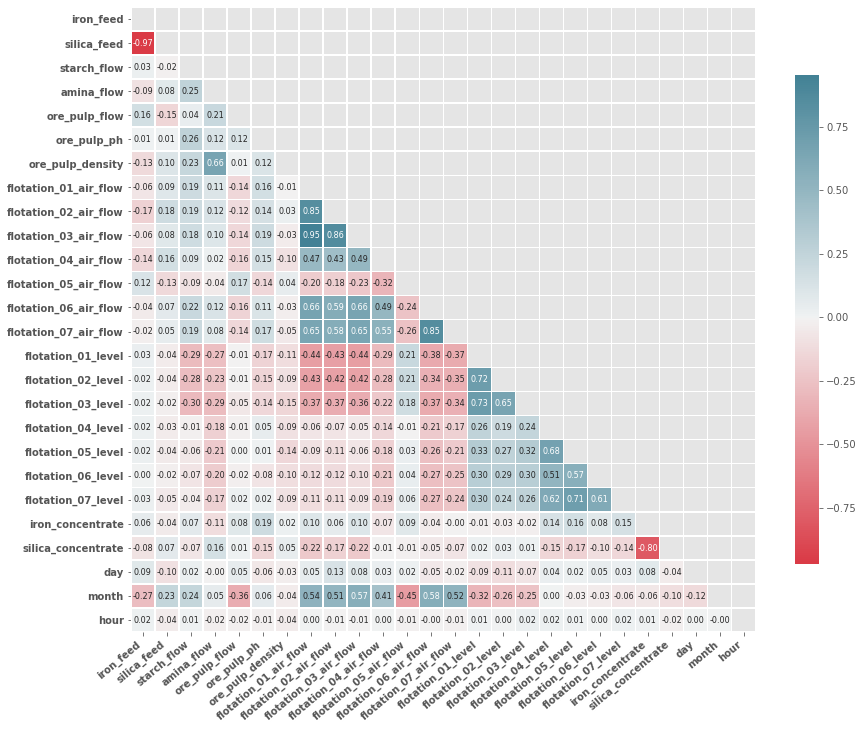

In [20]:
# PLOTANDO MATRIX DE CORRELAÇÃO

corr = df.corr()

# Gera uma máscara de zeros para triângulo superior damatrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Gera uma paletta de cores
cmap = sns.diverging_palette(10, 220, as_cmap=True)

plt.figure(figsize=(14,18))

ax = sns.heatmap(corr, 
                 annot = True, 
                 annot_kws = {'size': 8}, 
                 fmt = '.2f', 
                 mask=mask, 
                 cmap=cmap, 
                 center=0,
                 square=True, 
                 linewidths=.5, 
                 cbar_kws={"shrink": .5})

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 40,
                  horizontalalignment = 'right', 
                  fontweight='bold')

ax.set_yticklabels(ax.get_yticklabels(),
                  rotation = 0,
                  horizontalalignment = 'right', 
                  fontweight='bold')

plt.show()

In [21]:
# SELECIONA CORRELAÇÃO  DAS VARIÁVEIS ALVO, FORMATA E ADICIONA ESTILO AO DATAFRAME

corr_iron = corr[['iron_concentrate']].drop(labels=['iron_concentrate', 'silica_concentrate'], axis=0).sort_values(by=['iron_concentrate'], ascending=False).style.bar(color='#52BE80').set_table_attributes("style='display:inline;margin-right:200px'")

corr_silica = corr[['silica_concentrate']].drop(labels=['iron_concentrate', 'silica_concentrate'], axis=0).sort_values(by=['silica_concentrate'], ascending=False).style.bar(color='#52BE80').set_table_attributes("style='display:inline'")

In [22]:
display_html(corr_iron._repr_html_() + corr_silica._repr_html_(), raw=True)

,iron_concentrate
ore_pulp_ph,0.192992
flotation_05_level,0.160824
flotation_07_level,0.146508
flotation_04_level,0.137019
flotation_03_air_flow,0.100136
flotation_01_air_flow,0.098599
flotation_05_air_flow,0.088762
ore_pulp_flow,0.083120
flotation_06_level,0.082300
day,0.079683


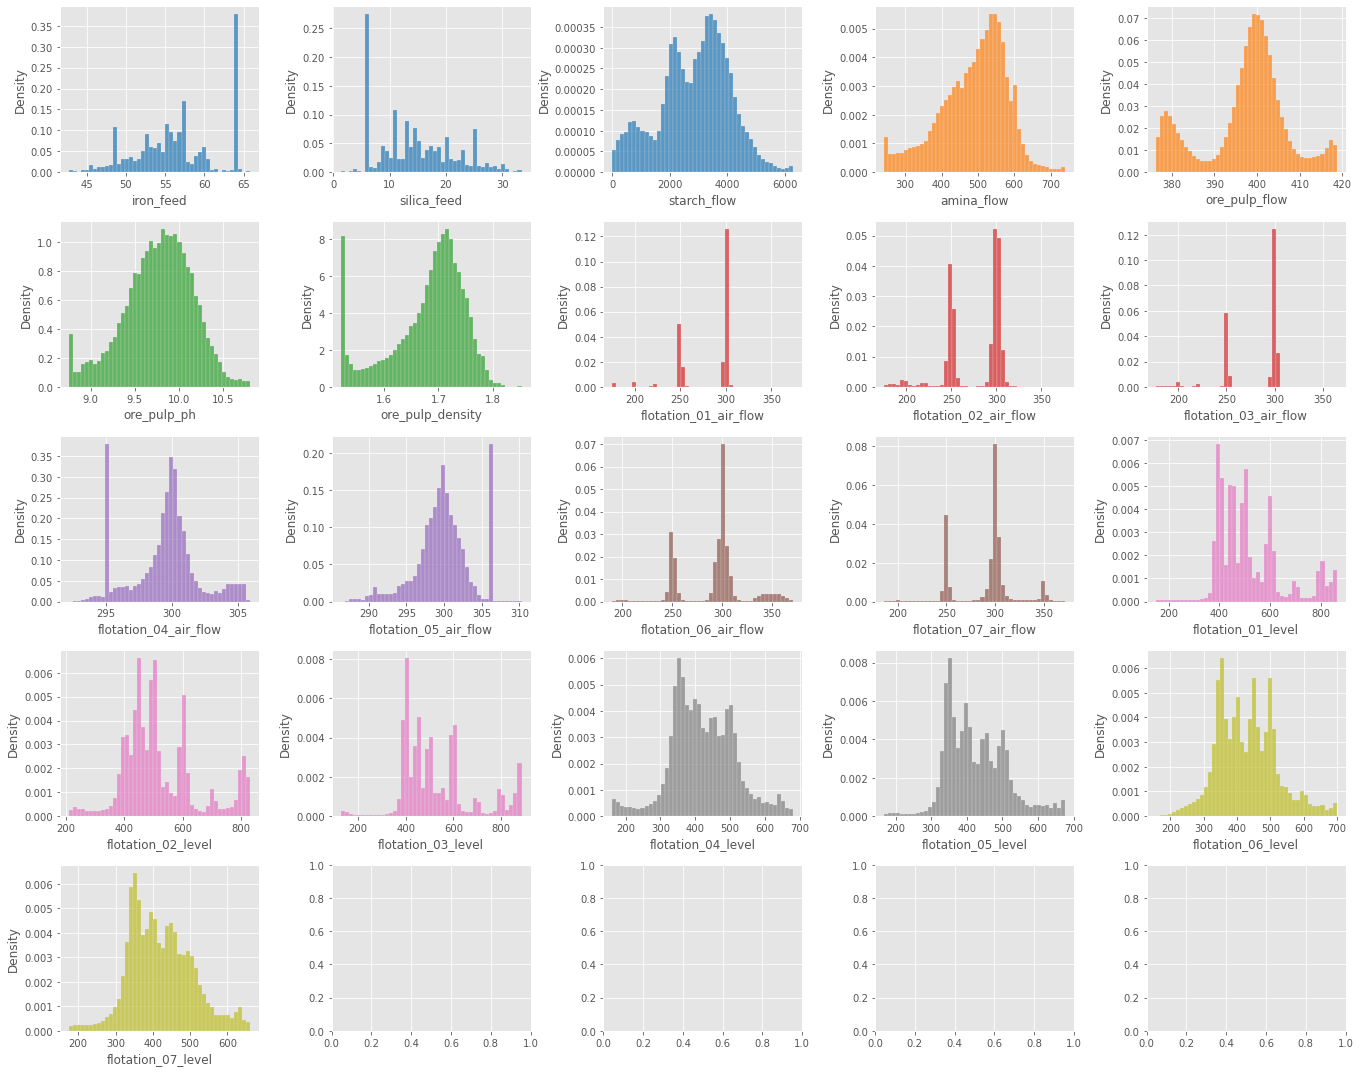

In [23]:
# PLOTA HISTOGRAMA DE CADA ATRIBUTO FLOAT DO CONJUNTO DE DADOS

df_temp = df.drop(columns=['datetime', 'date', 'iron_concentrate', 'silica_concentrate', 'day', 'month', 'hour'])

color_list = plt.cm.tab10(np.linspace(0, 1, 24)[list(range(24))+[0, 1]])
feat_clrs = {k: rgb2hex(color_list[i][:3]) for i, k in enumerate(df_temp.columns)} if color_list is not None else {}

n_cols = 5
n_rows = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.8*n_cols, n_rows*3))

for i, (ax, col) in enumerate(zip(axes.flatten(), list(df_temp.columns))):
    sns.histplot(df_temp[col], color=feat_clrs[col], ax=ax, kde=False, stat="density", linewidth=0.2, bins=45, alpha=0.7)
        
plt.tight_layout()

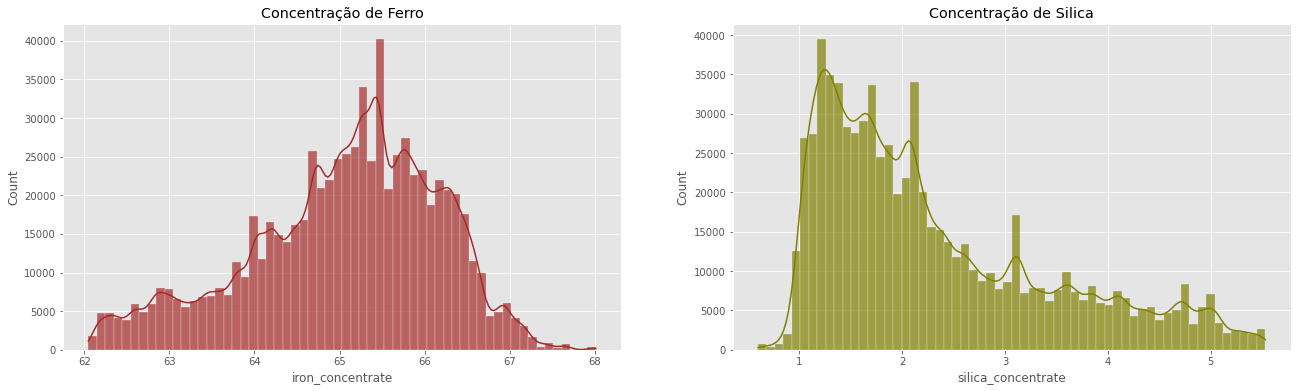

In [24]:
# PLOTANDO DISTRIBUIÇÃO DAS VARIÁVEIS ALVO

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,6))

# Gráfico 01
ax[0].set_title("Concentração de Ferro")
sns.histplot(data=df, x='iron_concentrate', ax=ax[0], kde=True, linewidth=0.3, bins=60, alpha=0.7, color='brown')

# Gráfico 02
ax[1].set_title("Concentração de Silica")
sns.histplot(data=df, x='silica_concentrate', ax=ax[1], kde=True, linewidth=0.3, bins=60, alpha=0.7, color='olive');

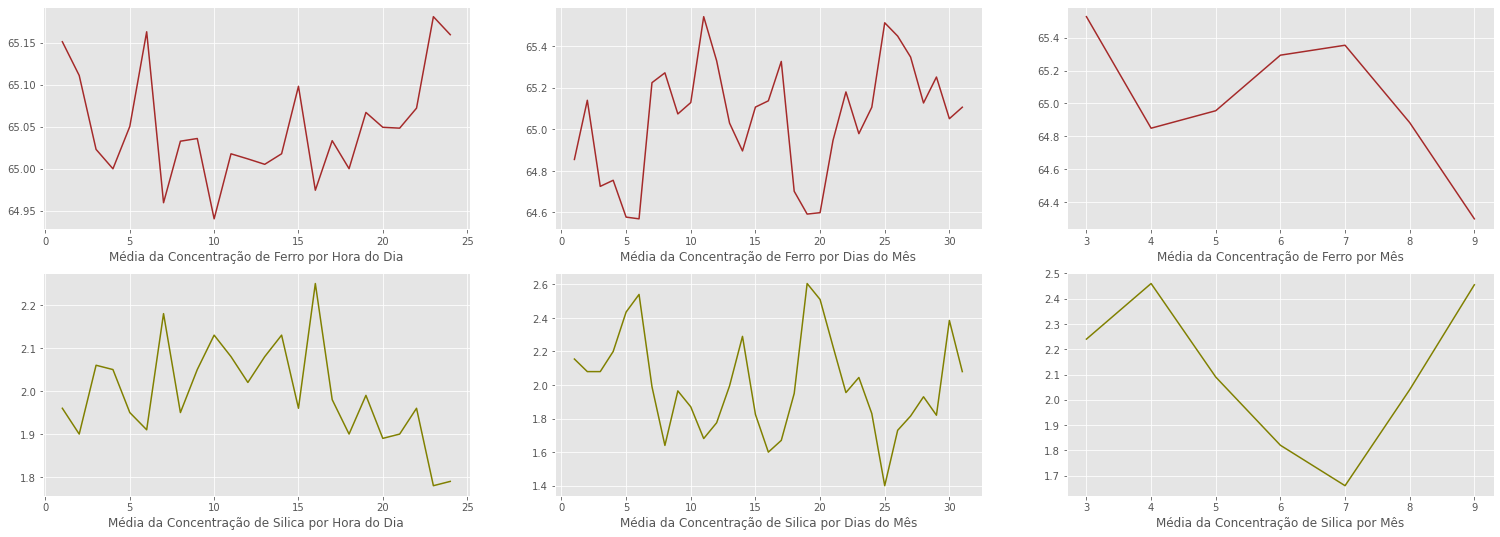

In [25]:
# PLOTANDO SEPARADAMENTE A MÉDIA DOS VALORES DAS VARIÁVEIS ALVO EM RELAÇÃO A HORA, DIA E MÊS

plt.figure(figsize=(26,9))

ax1 = plt.subplot(2,3,1)
df.groupby('hour')['iron_concentrate'].mean().plot(color='brown')
plt.xlabel('Média da Concentração de Ferro por Hora do Dia')

ax2 = plt.subplot(2,3,2)
df.groupby('day')['iron_concentrate'].mean().plot(color='brown')
plt.xlabel('Média da Concentração de Ferro por Dias do Mês')

ax3 = plt.subplot(2,3,3)
df.groupby('month')['iron_concentrate'].mean().plot(color='brown')
plt.xlabel('Média da Concentração de Ferro por Mês')

ax4 = plt.subplot(2,3,4)
df.groupby('hour')['silica_concentrate'].median().plot(color='olive')
plt.xlabel('Média da Concentração de Silica por Hora do Dia')

ax5 = plt.subplot(2,3,5)
df.groupby('day')['silica_concentrate'].median().plot(color='olive')
plt.xlabel('Média da Concentração de Silica por Dias do Mês')

ax6 = plt.subplot(2,3,6)
df.groupby('month')['silica_concentrate'].median().plot(color='olive')
plt.xlabel('Média da Concentração de Silica por Mês')

plt.show()

# <center>Definindo Dados de Treino e Teste

In [26]:
# DADOS DE TREINO
x_train = df_train.drop(columns=['silica_concentrate', 'iron_concentrate', 'datetime', 'date', 'day', 'month', 'hour'])
y_train = df_train[['silica_concentrate', 'iron_concentrate']]
iron_train = df_train[['iron_concentrate']]
silica_train = df_train[['iron_concentrate']]

# DADOS DE TESTE
x_test = df_test.drop(columns=['silica_concentrate', 'iron_concentrate', 'datetime', 'date', 'day', 'month', 'hour'])
y_test = df_test[['silica_concentrate', 'iron_concentrate']]
iron_test = df_test[['iron_concentrate']]
silica_test = df_test[['iron_concentrate']]

In [27]:
# CRIANDO OBJETO PARA PADRONIZAÇÃO DOS DADOS EM UMA MESMA ESCALA 
# (métodos ensemble geralmente não necessitam de normalização mas mesmo podemos encontramos pequenas melhoras)

scaler = MinMaxScaler()

In [28]:
# TREINANDO OBJETO COM DADOS DE TREINO
scaler.fit(x_train)

# TRANSFORMANDO DADOS DE TREINO
x_train_scaled = scaler.transform(x_train)

# TRANSFORMANDO DADOS DE TESTE
x_test_scaled = scaler.transform(x_test)

# <center>Treinamento do Modelo

In [29]:
# DICIONÁRIO COM HYPERPARÂMETROS E ESPAÇO DE VALORES A SEREM TESTADOS

param_grid = {
            'max_depth': hp.quniform('max_depth', 6, 15, 3), 
            'n_estimators': hp.quniform('n_estimators', 80, 240, 80), 
            'learning_rate': hp.quniform('learning_rate', 0.3, 1.5, 0.3), 
            'booster': hp.choice('booster', ['gbtree']), 
            'min_child_weight': hp.quniform('min_child_weight', 0, 6, 2)
}

In [30]:
# FUNÇÃO DE TREINAMENTO DO MODELO E RETORNANDO PONTUAÇÃO

def objective(params):
    
    params_dict = { 
        'max_depth': int(params['max_depth']), 
        'n_estimators': int(params['n_estimators']), 
        'learning_rate': params['learning_rate'], 
        'booster': params['booster'], 
        'min_child_weight': params['min_child_weight'], 
        'random_state': 1000
    }
    
    # Criação do modelo XGBoost
    gbm = xgb.XGBRegressor(**params_dict)
    
    # Validação cruzada
    score = cross_val_score(gbm, x_train, iron_train, scoring='neg_root_mean_squared_error', cv=3, n_jobs=4)
    
    loss = -score.mean()
    loss_variance = score.std()
    
    try:
        return {
            'loss': loss,
            'loss_variance':loss_variance,
            'status': STATUS_OK,
            }
    except Exception as e:
        return {
            'exception': str(e),
            'status': STATUS_FAIL,
            }

In [31]:
# CRIANDO OBJETO QUE FARÁ A OTIMIZAÇÃO DOS PARÂMETROS REALIZANDO A MINIMIZAÇÃO DO DADO DE SAÍDA DA FUNÇÃO CRIADA ACIMA.

# OBSERVAÇÃO: foi utilizado a busca com poucas iterações devido o elevado tempo de processamento. 
#             Durante testes realizados com mais iterações a execução durou mais 5 horas e com meu notebook travando bastante.
#             Mesmo assim foi encontrato excelentes valores de acurácia. Destacando a eficiência do algoritmo do Hyperopt.
#             Com essas informações podemos prever que com mais iterações obiteremos melhores resultados.

trials = Trials()

random_search = fmin(
                    fn = objective,
                    space = param_grid,
                    max_evals = 10,
                    rstate = np.random.RandomState(42), 
                    trials = trials, 
                    algo = tpe.suggest)

100%|██████████| 10/10 [1:03:10<00:00, 379.08s/trial, best loss: 1.354947390088005]


In [32]:
random_search

{'booster': 0,
 'learning_rate': 0.6,
 'max_depth': 6.0,
 'min_child_weight': 4.0,
 'n_estimators': 160.0}

In [33]:
# CRIANDO DATAFRAME COM OS VALORES USADOS EM CADA ITERAÇÃO DO ALGORITMO E SEUS RESPECTIVOS RESULTADOS 

df_results = pd.concat([
                pd.DataFrame(trials.vals), 
                pd.DataFrame(trials.results)], 
                axis=1,
            ).sort_values(by='loss', ascending=False).reset_index(drop=True)

df_results['index'] = df_results.index

# VISUALIZAÇÃO DO DATAFRAME
df_results.head(10)

,booster,learning_rate,max_depth,min_child_weight,n_estimators,loss,loss_variance,status,index
0,0,1.5,9.0,6.0,240.0,2.689561,0.289459,ok,0
1,0,1.2,9.0,4.0,160.0,2.028676,0.198682,ok,1
2,0,1.2,9.0,6.0,160.0,1.958102,0.202302,ok,2
3,0,1.2,12.0,2.0,240.0,1.909261,0.159540,ok,3
4,0,1.2,12.0,2.0,240.0,1.909261,0.159540,ok,4
5,0,0.9,15.0,4.0,240.0,1.621558,0.167867,ok,5
6,0,0.9,6.0,6.0,160.0,1.555446,0.093531,ok,6
7,0,0.6,6.0,6.0,160.0,1.385149,0.166712,ok,7
8,0,0.6,15.0,4.0,160.0,1.366608,0.113650,ok,8
9,0,0.6,6.0,4.0,160.0,1.354947,0.145676,ok,9


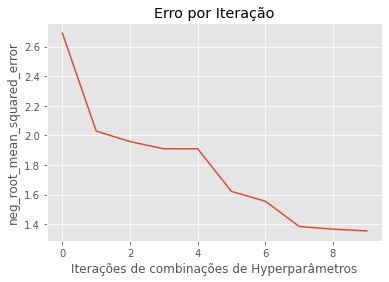

In [34]:
# PLOT DA CURVA DE ACURÁCIA ATRAVÉS DAS ITERAÇÕES DO ALGORITMO DE OTIMIZAÇÃO

df_results['loss'].plot()
plt.ylabel('neg_root_mean_squared_error')
plt.xlabel('Iterações de combinações de Hyperparâmetros')
plt.title('Erro por Iteração')
plt.show()

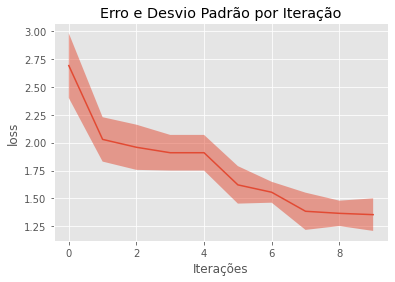

In [35]:
# PLOT DA CURVA DE ERRO DO MODELO COM O DESVIO PADRÃO POR ITERAÇÕES DO ALGORITMO DE OTIMIZAÇÃO

ax = sns.lineplot(x=r'index', y='loss', data=df_results)

ax.fill_between(
    df_results["index"],
    y1=df_results["loss"] - df_results["loss_variance"],
    y2=df_results["loss"] + df_results["loss_variance"],
    alpha=.5,
)

plt.xlabel('Iterações')
plt.title('Erro e Desvio Padrão por Iteração')
plt.show()

In [36]:
# CRIANDO DICIONÁRIO COM OS MELHORES HYPERPARÂMETROS ENCONTRADOS NA OTIMIZAÇÃO

def create_param_grid(search, booster):
    best_hp_dict = {
            'max_depth': int(search['max_depth']), 
            'n_estimators': int(search['n_estimators']), 
            'learning_rate': search['learning_rate'], 
            'booster': booster, 
            'random_state': 1000,
    }
    return best_hp_dict

## Criando Modelo Final

In [37]:
# CRIANDO MANUALMENTE MODELO FINAL COM OS MELHORES PARÂMETROS ENCONTRADOS PELO ALGORITMO HYPEROPT

best_params = create_param_grid(random_search, 'gbtree')

xgb_model = xgb.XGBRegressor(**best_params)

## Treinando Modelo Final

In [80]:
# Não está sendo usado a normalização dos dados
#x_train_scaled = pd.DataFrame(data=x_train, columns=[x_train.columns])

In [39]:
# TREINANDO MODELO FINAL

xgb_model.fit(x_train, iron_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.6, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=160, n_jobs=8, num_parallel_tree=1, random_state=1000,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Fazendo Previsões Final

In [40]:
# REALIZANDO PREVISÕES COM O MODELO

predictions = xgb_model.predict(x_train)

## Acurácia do Modelo Final

In [41]:
# AVALIAÇÃO DO MODELO

print('\033[1mR2 SCORE: {:.5f}\033[0m'.format(r2_score(iron_train, predictions)))

R2 SCORE: 0.82689


### Testes com a eliminação de alguns atributos

Por meio do método 'feature_importances' do algorimo XGBoost podemos ver a importância de cada atributo para o modelo.

Sendo assim, tentaremos obter uma acurácia melhor fazendo a exclução dos atributos menos significantes.

In [42]:
feature_importance = pd.DataFrame(data=xgb_model.feature_importances_.reshape(-1,1), index=x_train.columns, columns=['importance'])

In [43]:
# ATRIBUINDO PALETA DE CORES
colors = sns.color_palette("crest", as_cmap=True)

# PLOTANDO IMPORTÂNCIA DE CADA ATRIBUTO
feature_importance.sort_values(by=['importance'], ascending=False).style.background_gradient(cmap=colors)

,importance
silica_feed,0.118710
flotation_03_air_flow,0.105791
flotation_04_air_flow,0.098849
iron_feed,0.081038
flotation_05_level,0.068016
flotation_01_air_flow,0.056350
flotation_05_air_flow,0.053982
flotation_03_level,0.044823
flotation_02_level,0.042469
flotation_06_level,0.040200


In [57]:
# REMOVENDO OS 2 ATRIBUTOS MENOS SIGNIFICANTES PARA O ALGORITMO
important_features = list(feature_importance.sort_values(by=['importance'], ascending=False)[:-2].index)

In [67]:
x_train_important = pd.DataFrame(data=x_train[important_features], columns=important_features)

In [69]:
# CRIANDO E TREINANDO O MODELO NOVAMENTE COM O NOVO CONJUNTO DE DADOS

xgb_model_important = xgb.XGBRegressor(**best_params)

xgb_model_important.fit(x_train_important, iron_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.6, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=160, n_jobs=8, num_parallel_tree=1, random_state=1000,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
# REALIZANDO PREVISÕES
predictions = xgb_model_important.predict(x_train_important)

In [71]:
# ACURÁCIA DO MODELO
print('\033[1m R2 SCORE: {:.5f} \033[0m'.format(r2_score(iron_train, predictions)))

R2 SCORE: 0.83199


Depois de fazer os testes e avaliação, chegamos a conclusão que a eliminação dos dois atributos menos influentes do modelo resultou em uma pequena melhora de performace.

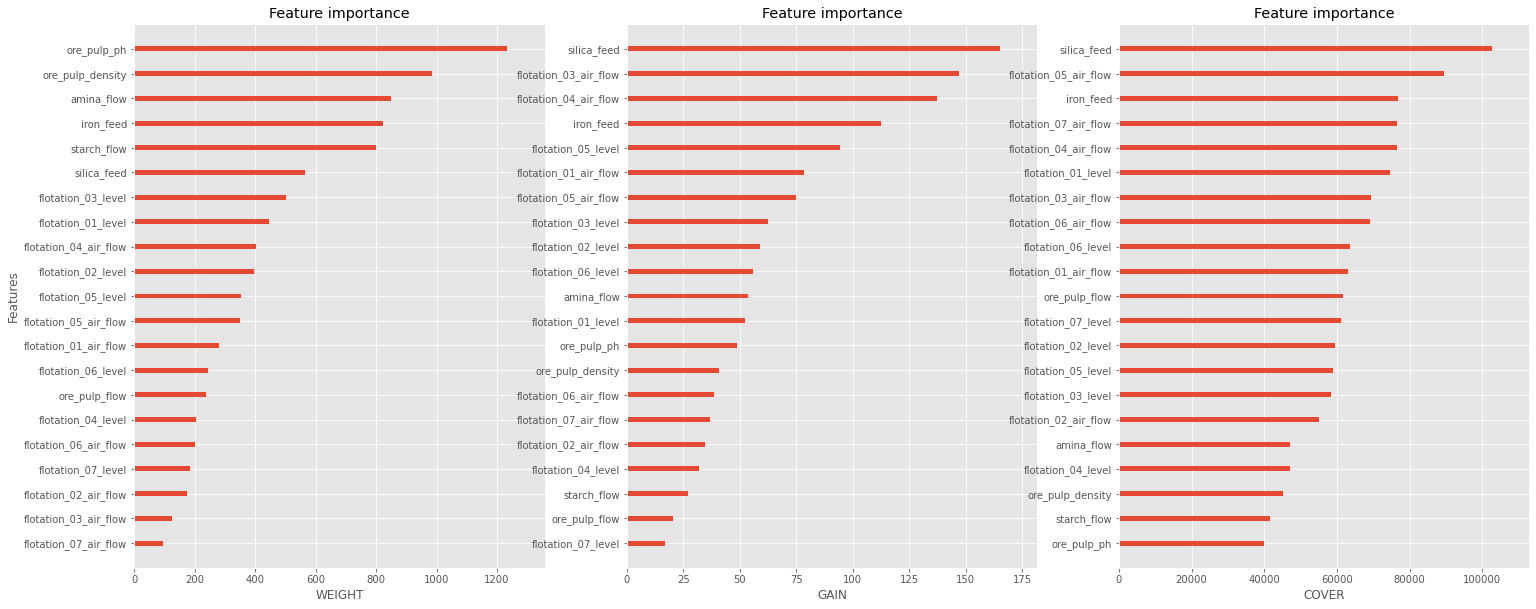

In [72]:
# AQUI PODEMOS VISUALIZAR A IMPORTÂNCIA DE CADA ATRIUTO POR MEIO DE DIFERENTES FATORES INTERNOS DO PRÓPRIO ALGORITMO XGBoost

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,10))

plot_importance(xgb_model, ax[0], importance_type='weight', show_values=False, xlabel='WEIGHT')
plot_importance(xgb_model, ax[1], importance_type='gain', show_values=False, xlabel='GAIN', ylabel='')
plot_importance(xgb_model, ax[2], importance_type='cover', show_values=False, xlabel='COVER', ylabel='')
plt.show()

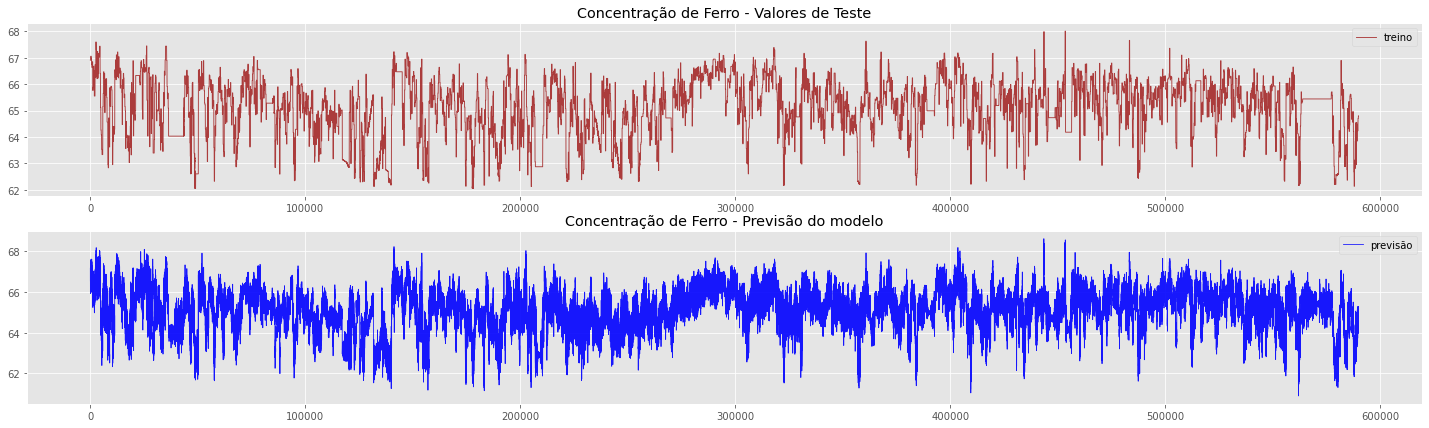

In [73]:
# PLOTANDO GRÁFICO PARA COMPARAÇÃO DOS VALORES REAIS E OS VALORES PREVISTOS PELO MODELO

plt.figure(figsize=(25, 7))

ax1 = plt.subplot(2,1,1)
x_ax = range(len(iron_train))
plt.plot(x_ax, iron_train, label="treino", linewidth=0.9, alpha=0.9, color='brown')
plt.title("Concentração de Ferro - Valores de Teste")
plt.legend()

ax2 = plt.subplot(2,1,2)
x_ax = range(len(iron_train))
plt.plot(x_ax, predictions, label="previsão", linewidth=0.8, alpha=0.9, color='blue')
plt.title("Concentração de Ferro - Previsão do modelo")
plt.legend()

plt.show()

# <center>Avaliação com Dados de Teste

In [74]:
# REALIZANDO PREVISÕES
predictions = xgb_model.predict(x_test)

In [79]:
# ACURÁCIA DO MODELO
print('\033[1m R2 SCORE: {:.5f} \033[0m'.format(-r2_score(iron_test, predictions)))

 R2 SCORE: 0.81404 


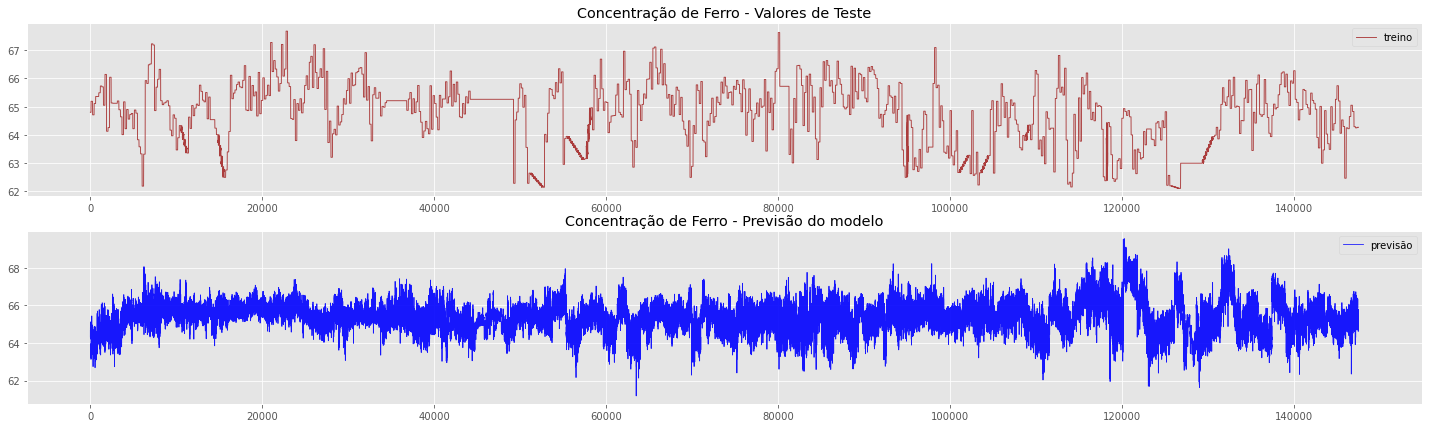

In [78]:
# PLOTANDO GRÁFICO PARA COMPARAÇÃO DOS VALORES REAIS E OS VALORES PREVISTOS PELO MODELO

plt.figure(figsize=(25, 7))

ax1 = plt.subplot(2,1,1)
x_ax = range(len(iron_test))
plt.plot(x_ax, iron_test, label="treino", linewidth=0.9, alpha=0.9, color='brown')
plt.title("Concentração de Ferro - Valores de Teste")
plt.legend()

ax2 = plt.subplot(2,1,2)
x_ax = range(len(iron_test))
plt.plot(x_ax, predictions, label="previsão", linewidth=0.8, alpha=0.9, color='blue')
plt.title("Concentração de Ferro - Previsão do modelo")
plt.legend()

plt.show()

### Considerações Finais:

Foi realizado a previsão somente da porcentagem da concentração de ferro. Para a previsão da concentração de sílica seria necessário treinar o algoritmo 
com os dados da sílica ao invez do ferro. Mas mantendo o mesmo procedimento.

Não realizei devido a alta demanda de processamento que o algoritmo Hyperopt demanda. Em meus testes houve treinamentos do algoritmo de otimização que duraram mais de 5 horas.

Por fim, o modelo final tem espaço para bastante melhora da acurácia, uma vez que o objetivo foi colocar em prática o desenvolvimento de um modelo de machine learning 
usando o algoritmo XGBoost e a biblioteca Hyperopt para otimização.